In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.download('BTC-USD')
btc_df = btc_df.reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Adj Close', 'Volume', 'Unnamed: 0'])
df = df.rename(columns={"value": "wallets"})
df
#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

[*********************100%***********************]  1 of 1 completed


,date,price,wallets,address,mined
0,2010-09-25,0.100000,2.0,656.0,4109450.0
1,2010-09-26,0.100000,2.0,444.0,4110750.0
2,2010-09-27,0.100000,2.0,1070.0,4132150.0
3,2010-09-28,0.100000,2.0,1503.0,4133200.0
4,2010-09-29,0.100000,2.0,1049.0,4148050.0
...,...,...,...,...,...
4416,2022-11-25,16521.841797,NaN,NaN,NaN
4417,2022-11-26,16464.281250,NaN,NaN,NaN
4418,2022-11-27,16444.626953,NaN,NaN,NaN
4419,2022-11-28,16217.322266,NaN,NaN,NaN


In [2]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years =1
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

09:55:53 - cmdstanpy - INFO - Chain [1] start processing
09:55:56 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4781,2023-11-25,50645.643691,40384.372898,60098.643214
4782,2023-11-26,50737.280639,40480.525965,60430.102826
4783,2023-11-27,50865.494002,41490.716205,60403.614594
4784,2023-11-28,50958.223926,41347.705004,60493.748021
4785,2023-11-29,51119.636837,41417.952422,60921.442306


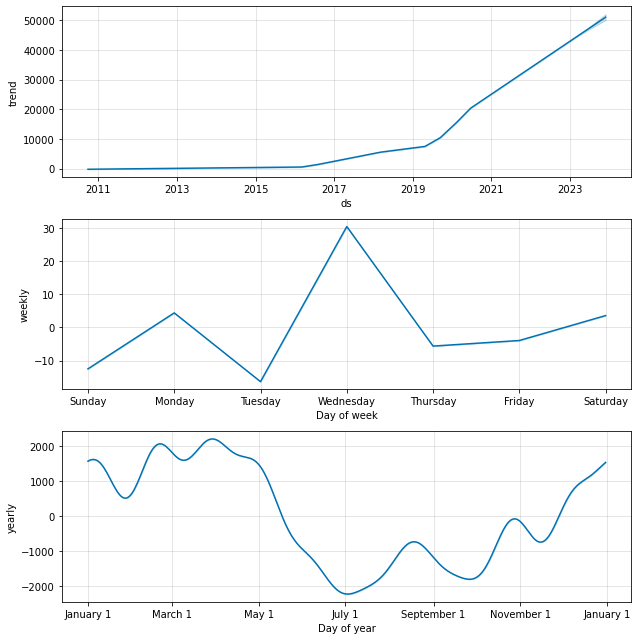

In [4]:
fig2 = m.plot_components(forecast)

In [5]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

09:55:59 - cmdstanpy - INFO - Chain [1] start processing
09:56:00 - cmdstanpy - INFO - Chain [1] done processing
09:56:00 - cmdstanpy - INFO - Chain [1] start processing
09:56:01 - cmdstanpy - INFO - Chain [1] done processing


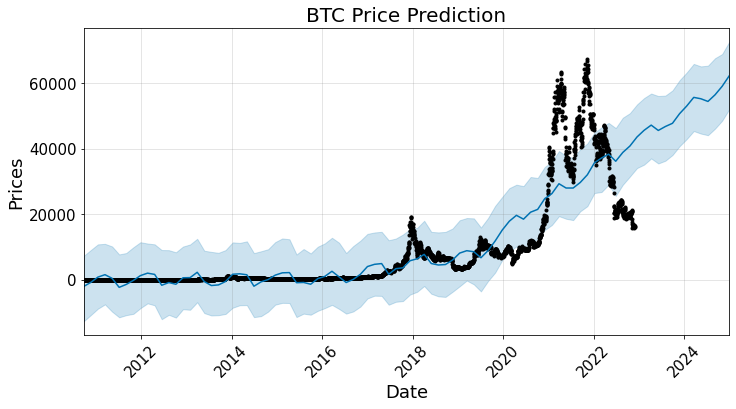

<Figure size 432x288 with 0 Axes>

In [6]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-12-31", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-12-31'])) 
plt.show();
plt.savefig("../static/logprices.png")

In [7]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_train.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(r2_score(metric_df.y, metric_df.yhat))
print(mean_squared_error(metric_df.y, metric_df.yhat))
print(mean_absolute_error(metric_df.y, metric_df.yhat))

0.7252148072558613
58580928.035394564
4461.946545537185


In [9]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df['date'], y=df['price'], legendrank=4))
fig.add_trace(go.Scatter(name="Middle Bound Prediction", x=prediction['ds'], y=(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=(prediction['yhat_upper']), legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
# fig.update_yaxes(type="log")
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prices and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Prices")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=5, r=120, t=70, b=50),
)


fig.layout.template = 'plotly_dark'
fig.write_html('../static/prices.html')
fig.show()